# Cutting plane and bundle methods
The second part of the tutorial focuses on cutting plane and bundle
methods. We aim at resolving the following LASSO problem:
$$
\min_r \;f(r) =  \| A u - b \|_2^2 + \lambda \|u \|_1
$$
with $\lambda$ a given regularization parameter, $X$ and $b$ input data.

## Table of contents <a name="toc"></a>

1. [Settings](#settings)
2. [Cuutting plane algorithm](#cutting)
3. [Bundle algorithm](#bundle)
4. [Final results on simulated data](#simulated)
    1. [First results](#res_sim)
    2. [Influence of the regularization](#reg_sim)
    3. [Impact of the normalization](#norm_sim)
5. [Final results on real data](#real)
    1. [First results](#res_real)
    2. [Influence of the regularization](#reg_real)
    3. [Impact of the normalization](#norm_real)


## Settings
We import the usual packages:

In [1]:
using Printf, Random
using LinearAlgebra
using ForwardDiff
using JuMP, CPLEX

Fix seed

In [2]:
Random.seed!(2713);

Some constants

In [3]:
const LB = 0 #For CPLEX
const UB =  1e20
const SOLVER = CPLEX.Optimizer

CPLEX.Optimizer

We first generate artificial data to study the algorithm:

In [4]:
include("data.jl")

nVariables = 10;
nCassures = 10;
xMin, xMax = build_bounds(nVariables)
A = build_X(nVariables, nCassures, xMin, xMax);
b = randn(nCassures);
λ = 50.0;

Build oracle for objective:

In [5]:
f(u) = 0.5 * norm(A*u - b, 2)^2 + λ * norm(u, 1);

Function that gets the actual solution:

In [6]:
function get_solution(A, b, λ)
    n, m = size(A)
    model = Model(SOLVER)
    JuMP.set_silent(model)
    set_optimizer_attribute(model, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    # Variable u
    @variable(model, u[1:n])
    # Variable t, linearizing the \|.\|_1 term
    @variable(model, t[1:n])
    @constraint(model, t .>= u)
    @constraint(model, t .>= -u)
    @objective(model, Min, 0.5 * dot(A*u - b, A*u - b) + λ * sum(t))
    JuMP.optimize!(model)
    return JuMP.objective_value(model)
end
optsol = get_solution(A, b, λ)
println("Optimal solution is equal to ", optsol)

Optimal solution is equal to 5.0541025315605985


## A note on the choice of solvers : 

Despite CPLEX being the faster solver of the two, we generally preferred using OSQP here due to numerical issues. In particular, here are a couple of our observations.
- CPLEX (sometimes ?) does not deal very well with the very low lower bound LB. It appears that the bound is so low that it believes the problem to be unbounded (especially using the bundle method). Here we have an obvious reasonable lower bound of 0, but that might not be the case in other applications.
- In the bundle method, even when setting $\alpha \geq 0$ instead of LB, we have numerical instability depending on the precision threshold \"tol\". If too precise, CPLEX will also run into a problem it deems impossible to solve, and the algorithm will terminate too early."

## Cutting plane
The cutting plane method builds a proxy $\underline{f}_k$ for the original
function $f$, such that $\underline{f}_k$ is polyhedral and is a lower approximation:
$$
\underline{f}_k \leq f \quad \forall k
$$
If we have at disposal a collection of point $x_1, \cdots, x_k$,
with associated subgradients $g_1, \cdots, g_k$, the function
$\underline{f}_k$ writes out
$$
\begin{aligned}
f_k(x) = min_x \;& \theta  \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k)
\end{aligned}
$$

We can define the cutting plane algorithm as follows.

In [7]:
function launch_cutting_plane(X, xMin, xMax, maxit=5000)
    master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX

    @variable(master, α >= LB) 
    @variable(master, xMin[i] <= x[i in 1:size(X,1)] <= xMax[i])
    @objective(master, Min, α)
    
    lb, ub = LB, UB

    best_ub = ub

    epsilon = 1e-8
    
    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]
    
    for n_iter in 1:maxit
        println("Iteration : ",n_iter)
        JuMP.optimize!(master)
        lb = JuMP.value(α)
        x_k = JuMP.value.(x)
        f_k = f(x_k)
        println("Lower bound : ", lb)
        println("Valeur au point courant : ", f_k)
        g_k = ForwardDiff.gradient(f, x_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        if (f_k - lb <= epsilon)
            return trace_f, trace_ub, trace_lb, n_iter
            break
        else
            @constraint(master, α >= f_k + sum(g_k[i]*(x-x_k)[i] for i in 1:size(X,1)))
        end
    end
    return trace_f, trace_ub, trace_lb, maxit
end;

In [8]:
trace_cutting_plane_f, trace_cutting_plane_ub, trace_cutting_plane_lb, n_cutting_plane  = launch_cutting_plane(A,xMin,xMax)

Iteration : 1
Lower bound : 0.0
Valeur au point courant : 8.881330164947744e6
Iteration : 2
Lower bound : 0.0
Valeur au point courant : 4.2405402773302505e6
Iteration : 3
Lower bound : 0.0
Valeur au point courant : 1.563300208359224e6
Iteration : 4
Lower bound : 0.0
Valeur au point courant : 1.8450035151468567e6
Iteration : 5
Lower bound : 0.0
Valeur au point courant : 1.8423293662163655e6
Iteration : 6
Lower bound : 0.0
Valeur au point courant : 2.669615431579714e6
Iteration : 7
Lower bound : 0.0
Valeur au point courant : 1.3376513995417422e6
Iteration : 8
Lower bound : 0.0
Valeur au point courant : 2.041235750929141e6
Iteration : 9
Lower bound : 0.0
Valeur au point courant : 1.51917123839853e6
Iteration : 10
Lower bound : 0.0
Valeur au point courant : 1.02964903749743e6
Iteration : 11
Lower bound : 0.0
Valeur au point courant : 1.221582403431801e6
Iteration : 12
Lower bound : 0.0
Valeur au point courant : 856798.4893378295
Iteration : 13
Lower bound : 0.0
Valeur au point courant : 93

Iteration : 122
Lower bound : 0.0
Valeur au point courant : 14711.344440439978
Iteration : 123
Lower bound : 0.0
Valeur au point courant : 7431.220203107287
Iteration : 124
Lower bound : 0.0
Valeur au point courant : 18621.26305617789
Iteration : 125
Lower bound : 0.0
Valeur au point courant : 11449.763193171717
Iteration : 126
Lower bound : 0.0
Valeur au point courant : 9766.241507878387
Iteration : 127
Lower bound : 0.0
Valeur au point courant : 6782.892861144112
Iteration : 128
Lower bound : 0.0
Valeur au point courant : 11142.117625614059
Iteration : 129
Lower bound : 0.0
Valeur au point courant : 6920.2940975872425
Iteration : 130
Lower bound : 0.0
Valeur au point courant : 8434.006968499276
Iteration : 131
Lower bound : 0.0
Valeur au point courant : 6308.086558406289
Iteration : 132
Lower bound : 0.0
Valeur au point courant : 6206.04922933222
Iteration : 133
Lower bound : 0.0
Valeur au point courant : 4909.962060483889
Iteration : 134
Lower bound : 0.0
Valeur au point courant : 6

Iteration : 239
Lower bound : 0.0
Valeur au point courant : 8.716856881735163
Iteration : 240
Lower bound : 0.0
Valeur au point courant : 40.05859450321305
Iteration : 241
Lower bound : 0.0
Valeur au point courant : 21.77016026866397
Iteration : 242
Lower bound : 0.0
Valeur au point courant : 21.20770190772589
Iteration : 243
Lower bound : 0.0
Valeur au point courant : 33.22959632963243
Iteration : 244
Lower bound : 0.17390409361433373
Valeur au point courant : 67.15007844795198
Iteration : 245
Lower bound : 0.3177320509594745
Valeur au point courant : 24.038427056210274
Iteration : 246
Lower bound : 1.1600554480608523
Valeur au point courant : 12.233508222349922
Iteration : 247
Lower bound : 1.3013012068811263
Valeur au point courant : 23.951582861871714
Iteration : 248
Lower bound : 1.5317991483599853
Valeur au point courant : 20.8758344688517
Iteration : 249
Lower bound : 1.6546044697586575
Valeur au point courant : 12.038637961837217
Iteration : 250
Lower bound : 2.109469963608563


Valeur au point courant : 5.054225157675936
Iteration : 351
Lower bound : 5.054074183259182
Valeur au point courant : 5.054179896265761
Iteration : 352
Lower bound : 5.054074431077752
Valeur au point courant : 5.054116921029852
Iteration : 353
Lower bound : 5.054076977655988
Valeur au point courant : 5.0541254140967435
Iteration : 354
Lower bound : 5.0540782494583985
Valeur au point courant : 5.05415238637511
Iteration : 355
Lower bound : 5.0540829812571495
Valeur au point courant : 5.054146536376794
Iteration : 356
Lower bound : 5.054088120219157
Valeur au point courant : 5.0541830998334465
Iteration : 357
Lower bound : 5.054091058364783
Valeur au point courant : 5.054134680685435
Iteration : 358
Lower bound : 5.054092514798198
Valeur au point courant : 5.054125484171683
Iteration : 359
Lower bound : 5.054093110258208
Valeur au point courant : 5.054110349173505
Iteration : 360
Lower bound : 5.05409534144953
Valeur au point courant : 5.054134544787771
Iteration : 361
Lower bound : 5.05

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 483
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 484
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 485
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 486
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 487
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 488
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 489
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 490
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 491
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 492
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iter

Valeur au point courant : 5.054103079701353
Iteration : 619
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 620
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 621
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 622
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 623
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 624
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 625
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 626
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 627
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 628
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 629
Lower bound : 5.0541

Valeur au point courant : 5.054103079701353
Iteration : 735
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 736
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 737
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 738
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 739
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 740
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 741
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 742
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 743
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 744
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 745
Lower bound : 5.0541

Iteration : 862
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 863
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 864
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 865
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 866
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 867
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 868
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 869
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 870
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 871
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 872
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 965
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 966
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 967
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 968
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 969
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 970
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 971
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 972
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 973
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 974
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iter

Valeur au point courant : 5.054103079701353
Iteration : 1075
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1076
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1077
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1078
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1079
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1080
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1081
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1082
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1083
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1084
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1085
Lower bou

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1188
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1189
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1190
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1191
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1192
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1193
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1194
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1195
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1196
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1197
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1289
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1290
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1291
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1292
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1293
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1294
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1295
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1296
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1297
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1298
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1390
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1391
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1392
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1393
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1394
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1395
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1396
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1397
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1398
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1399
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1484
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1485
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1486
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1487
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1488
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1489
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1490
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1491
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1492
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1493
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Valeur au point courant : 5.054103079701353
Iteration : 1662
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1663
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1664
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1665
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1666
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1667
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1668
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1669
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1670
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1671
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1672
Lower bou

Iteration : 1753
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1754
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1755
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1756
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1757
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1758
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1759
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1760
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1761
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1762
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1763
Lower bound : 5.054102286471145
Valeur au point coura

Valeur au point courant : 5.054103079701353
Iteration : 1928
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1929
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1930
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1931
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1932
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1933
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1934
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1935
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1936
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1937
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1938
Lower bou

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2081
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2082
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2083
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2084
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2085
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2086
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2087
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2088
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2089
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2090
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2230
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2231
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2232
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2233
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2234
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2235
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2236
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2237
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2238
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2239
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 2375
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2376
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2377
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2378
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2379
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2380
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2381
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2382
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2383
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2384
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2385
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2509
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2510
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2511
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2512
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2513
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2514
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2515
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2516
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2517
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2518
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2641
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2642
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2643
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2644
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2645
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2646
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2647
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2648
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2649
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2650
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2787
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2788
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2789
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2790
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2791
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2792
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2793
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2794
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2795
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2796
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2911
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2912
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2913
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2914
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2915
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2916
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2917
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2918
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2919
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2920
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3028
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3029
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3030
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3031
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3032
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3033
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3034
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3035
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3036
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3037
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3143
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3144
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3145
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3146
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3147
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3148
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3149
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3150
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3151
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3152
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3264
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3265
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3266
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3267
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3268
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3269
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3270
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3271
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3272
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3273
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3383
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3384
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3385
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3386
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3387
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3388
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3389
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3390
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3391
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3392
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 3485
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3486
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3487
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3488
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3489
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3490
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3491
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3492
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3493
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3494
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3495
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3579
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3580
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3581
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3582
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3583
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3584
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3585
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3586
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3587
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3588
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3682
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3683
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3684
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3685
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3686
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3687
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3688
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3689
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3690
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3691
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3791
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3792
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3793
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3794
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3795
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3796
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3797
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3798
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3799
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3800
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3897
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3898
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3899
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3900
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3901
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3902
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3903
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3904
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3905
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3906
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4002
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4003
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4004
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4005
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4006
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4007
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4008
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4009
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4010
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4011
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4104
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4105
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4106
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4107
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4108
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4109
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4110
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4111
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4112
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4113
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4195
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4196
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4197
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4198
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4199
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4200
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4201
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4202
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4203
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4204
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4314
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4315
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4316
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4317
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4318
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4319
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4320
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4321
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4322
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4323
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4435
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4436
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4437
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4438
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4439
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4440
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4441
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4442
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4443
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4444
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 4563
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4564
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4565
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4566
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4567
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4568
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4569
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4570
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4571
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4572
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4573
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4678
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4679
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4680
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4681
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4682
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4683
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4684
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4685
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4686
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4687
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 4788
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4789
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4790
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4791
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4792
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4793
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4794
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4795
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4796
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4797
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4798
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4902
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4903
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4904
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4905
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4906
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4907
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4908
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4909
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4910
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4911
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

([8.881330164947744e6, 4.2405402773302505e6, 1.563300208359224e6, 1.8450035151468567e6, 1.8423293662163655e6, 2.669615431579714e6, 1.3376513995417422e6, 2.041235750929141e6, 1.51917123839853e6, 1.02964903749743e6  …  5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353], [8.881330164947744e6, 4.2405402773302505e6, 1.563300208359224e6, 1.563300208359224e6, 1.563300208359224e6, 1.563300208359224e6, 1.3376513995417422e6, 1.3376513995417422e6, 1.3376513995417422e6, 1.02964903749743e6  …  5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  5.054102286471145, 5.054102286471145, 5.054102286471145, 5.054102286471145, 5.054102286471145, 5.054102286471145, 5.05410228647114

In [9]:
trace_cutting_plane_f[length(trace_cutting_plane_f)] - trace_cutting_plane_lb[length(trace_cutting_plane_lb)]

7.932302077406916e-7

In [10]:
trace_cutting_plane_f[length(trace_cutting_plane_f)] - optsol

5.481407541196859e-7

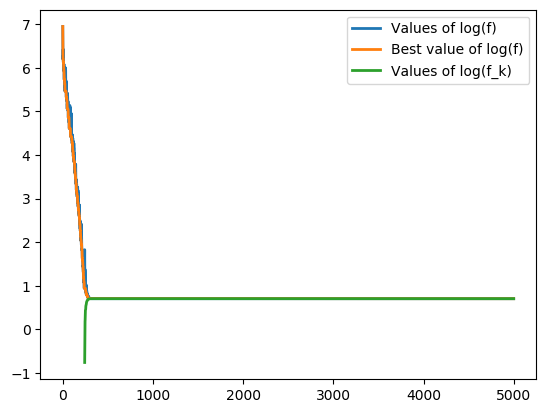

PyObject <matplotlib.legend.Legend object at 0x16470b850>

In [11]:
using PyPlot

plot(log10.(trace_cutting_plane_f), lw=2., label = "Values of log(f)")
plot(log10.(trace_cutting_plane_ub), lw=2., label ="Best value of log(f)")
plot(log10.(abs.(trace_cutting_plane_lb)), lw=2., label ="Values of log(f_k)")
legend()

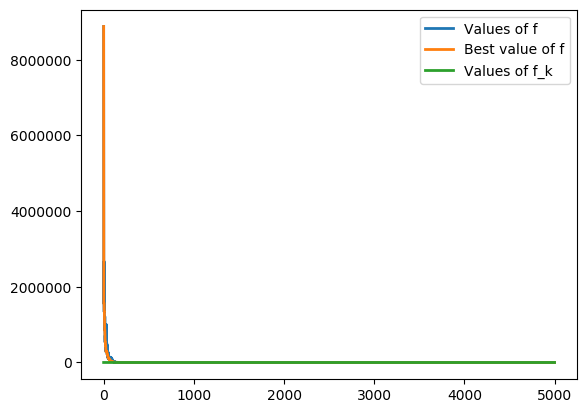

PyObject <matplotlib.legend.Legend object at 0x16acbffd0>

In [12]:
plot(trace_cutting_plane_f, lw=2., label = "Values of f")
plot(trace_cutting_plane_ub, lw=2., label ="Best value of f")
plot(trace_cutting_plane_lb, lw=2., label ="Values of f_k")
legend()

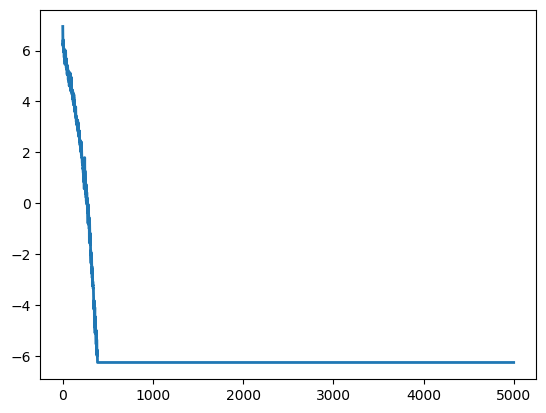

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x16b62b350>

In [13]:
plot(log10.(trace_cutting_plane_f .- optsol), lw=2.)

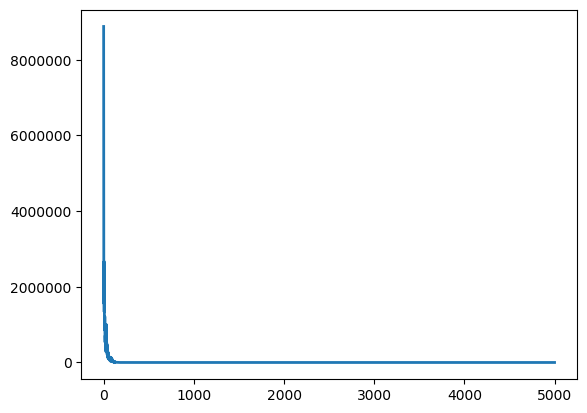

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x16b8a5a50>

In [14]:
plot(trace_cutting_plane_f .- optsol, lw=2.)

## Bundle algorithm
Comparing to the cutting plane method, the bundle algorithm adds a
quadratic penalization to the polyhedral proxy model.
The function .
$$
\begin{aligned}
f_k(x) = min_x \;& \theta + \frac 12 \| x - x_k \|_2^2 \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k)
\end{aligned}
$$

In [15]:
function launch_bundle(X, xMin, xMax, c=0.5, maxit=5000)
    master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    @variable(master, α >= LB)
    @variable(master, xMin[i] <= y[i in 1:size(X,1)] <= xMax[i])
    
    lb, ub = LB, UB

    best_ub = ub

    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]

    # Number of serious step
    nb_ss = 0
    # Number of null step
    nb_ns = 0
    weight = 1/(2*c)
    tol = 0.1
    EPS = 1e-8
    
    x_k = zeros(size(X,1))
    
    # The objective writes out as a QP
    @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1)))
    
    for n_iter in 1:maxit
        JuMP.optimize!(master)
        # println("Iteration ", n_iter)
        lb = JuMP.value(α)
        y_k = JuMP.value.(y)
        f_k = f(y_k)
        # println("Lower bound : ", lb)
        # println("Function value : ", f_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        f_x_k = f(x_k)
        delta_k = f_x_k - lb - weight*sum((y_k[i]-x_k[i])^2 for i in 1:size(X,1))
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        
        if delta_k <= EPS
            println("Optimum reached within epsilon threshold.")
            println("Number of serious steps :", nb_ss)
            println("Number of null steps :", nb_ns)
            return trace_f, trace_ub, trace_lb, n_iter, nb_ss, nb_ns
        else
            if f_x_k - f_k >= tol*delta_k
                # Serious step
                nb_ss += 1
                # println("Serious step.")
                x_k = y_k
                # We shall redefine the objective to take into account the new center
                @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1))) 
            else
                # Null step
                # println("Null step.")
                nb_ns += 1
            end
        end
        g_k = ForwardDiff.gradient(f, y_k)
        @constraint(master, α >= f_k + sum(g_k[i]*(y-y_k)[i] for i in 1:size(X,1)))
    end
    println("Number of serious steps :", nb_ss)
    println("Number of null steps :", nb_ns)
    return trace_f, trace_ub, trace_lb, maxit, nb_ss, nb_ns
end

launch_bundle (generic function with 3 methods)

In [16]:
trace_bundle_f, trace_bundle_ub, trace_bundle_lb, n_bundle, nb_ss, nb_ns = launch_bundle(A,xMin,xMax)

Optimum reached within epsilon threshold.
Number of serious steps :39
Number of null steps :156


([5.5995940672380655, 7.5722472376899255, 9.275417113985618, 14.095415683541308, 17.59268816842602, 39.98218534660518, 51.72427970449159, 84.60256900842923, 202.85198898618387, 63.51536495172119  …  5.054102548315633, 5.054102547156456, 5.054102559179465, 5.054102544193931, 5.054102557561326, 5.054102543653767, 5.054102554566241, 5.054102543604418, 5.054102538113179, 5.054102547923984], [5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655  …  5.054102548315633, 5.054102547156456, 5.054102547156456, 5.054102544193931, 5.054102544193931, 5.054102543653767, 5.054102543653767, 5.054102543604418, 5.054102538113179, 5.054102538113179], [0.0, 1.501079434785831e-10, 1.4464247741460596e-10, 6.302161067339904e-11, 2.3075646757011883e-11, 2.314028290204025e-10, 4.3423667092153524e-11, 1.6314564989963183e-11, 4.809358827312342e-11, 0.48391502624618327  

In [17]:
trace_bundle_f[length(trace_bundle_f)] - optsol

1.6363385313411527e-8

In [33]:
function launch_bundle_poly(X, xMin, xMax, maxit=5000)
master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    @variable(master, α >= LB)
    @variable(master, xMin[i] <= y[i in 1:size(X,1)] <= xMax[i])
    
    lb, ub = LB, UB

    best_ub = ub

    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]

    # Number of serious step
    nb_ss = 0
    # Number of null step
    nb_ns = 0
    step = "NONE"
    weight = 1.0 #c = 0.5
    EPS2 = 1e-8
    EPS = 1e-8
    
    x_k = zeros(size(X,1))
    
    # The objective writes out as a QP
    @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1)))
    
    for n_iter in 1:maxit
        JuMP.optimize!(master)
        # println("Iteration ", n_iter)
        lb = JuMP.value(α)
        y_k = JuMP.value.(y)
        f_k = f(y_k)
        # println("Lower bound : ", lb)
        # println("Function value : ", f_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        f_x_k = f(x_k)
        
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        
        if f_k - lb <= weight*sum((y_k[i]-x_k[i])^2 for i in 1:size(X,1))
            if sqrt(sum((y_k[i]-x_k[i])^2 for i in 1:size(X,1))) <= EPS
                println("Optimum reached within epsilon threshold.")
                println("Number of serious steps :", nb_ss)
                println("Number of null steps :", nb_ns)
                return trace_f, trace_ub, trace_lb, n_iter, nb_ss, nb_ns
            else
                # Serious step
                nb_ss += 1
                # println("Serious step.")
                x_k = y_k
                # We shall redefine the objective to take into account the new center
                @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1)))
                g_k = ForwardDiff.gradient(f, y_k)
                @constraint(master, α >= f_k + sum(g_k[i]*(y-y_k)[i] for i in 1:size(X,1)))
            end
        else
            if f_k - lb <= EPS2
                println("Optimum reached within epsilon2 threshold.")
                println("Number of serious steps :", nb_ss)
                println("Number of null steps :", nb_ns)
                return trace_f, trace_ub, trace_lb, n_iter, nb_ss, nb_ns
            else
                #Null step
                # println("Null step.")
                nb_ns += 1
                g_k = ForwardDiff.gradient(f, y_k)
                @constraint(master, α >= f_k + sum(g_k[i]*(y-y_k)[i] for i in 1:size(X,1)))
            end
        end  
    end
    println("Number of serious steps :", nb_ss)
    println("Number of null steps :", nb_ns)
    return trace_f, trace_ub, trace_lb, maxit, nb_ss, nb_ns
end

launch_bundle_poly (generic function with 2 methods)

In [34]:
trace_bundle_poly_f, trace_bundle_poly_ub, trace_bundle_poly_lb, n_bundle_poly, nb_ss_poly, nb_ns_poly = launch_bundle_poly(A,xMin,xMax)

Optimum reached within epsilon2 threshold.
Number of serious steps :1
Number of null steps :195


([5.5995940672380655, 7.5722472376899255, 9.275417113985618, 14.095415683541308, 17.59268816842602, 39.98218534660518, 51.72427970449159, 84.60256900842923, 202.85198898618387, 63.51536495172119  …  5.054102543811625, 5.054102552621424, 5.054102551723371, 5.0541025504588575, 5.054102548178779, 5.054102557419074, 5.054102548432806, 5.054102552008997, 5.054102550514111, 5.054102537420356], [5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655  …  5.054102543811625, 5.054102543811625, 5.054102543811625, 5.054102543811625, 5.054102543811625, 5.054102543811625, 5.054102543811625, 5.054102543811625, 5.054102543811625, 5.054102537420356], [0.0, 1.501079434785831e-10, 1.4464247741460596e-10, 6.302161067339904e-11, 2.3075646757011883e-11, 2.314028290204025e-10, 4.3423667092153524e-11, 1.6314564989963183e-11, 4.809358827312342e-11, 0.48391502624618327 

In [35]:
trace_bundle_poly_f[length(trace_bundle_poly_f)] - optsol

5.859757123971576e-9

In [32]:
trace_bundle_f[length(trace_bundle_f)] - optsol

1.6363385313411527e-8

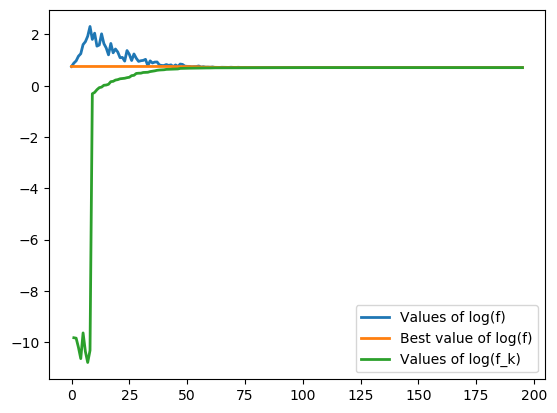

PyObject <matplotlib.legend.Legend object at 0x16b5aa650>

In [22]:
plot(log10.(trace_bundle_f), lw=2., label = "Values of log(f)")
plot(log10.(trace_bundle_ub), lw=2., label ="Best value of log(f)")
plot(log10.(abs.(trace_bundle_lb)), lw=2., label ="Values of log(f_k)")
legend()

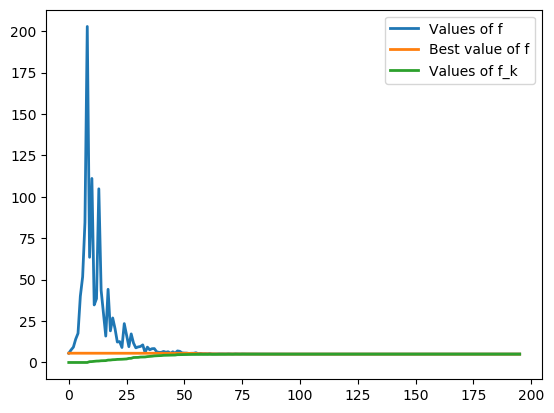

PyObject <matplotlib.legend.Legend object at 0x16be3efd0>

In [23]:
plot(trace_bundle_f, lw=2., label = "Values of f")
plot(trace_bundle_ub, lw=2., label ="Best value of f")
plot(trace_bundle_lb, lw=2., label ="Values of f_k")
legend()

In [24]:
trace_bundle_ub

196-element Array{Float64,1}:
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 ⋮                 
 5.0541025507817166
 5.0541025507817166
 5.054102548315633 
 5.054102547156456 
 5.054102547156456 
 5.054102544193931 
 5.054102544193931 
 5.054102543653767 
 5.054102543653767 
 5.054102543604418 
 5.054102538113179 
 5.054102538113179 

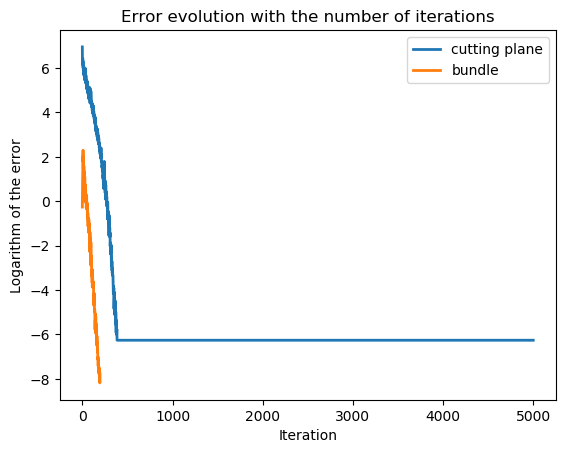

PyObject <matplotlib.legend.Legend object at 0x16d261190>

In [25]:
plot(log10.(trace_cutting_plane_f .- optsol), lw=2., label = "cutting plane")
plot(log10.(trace_bundle_f .- optsol), lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Logarithm of the error")
legend()

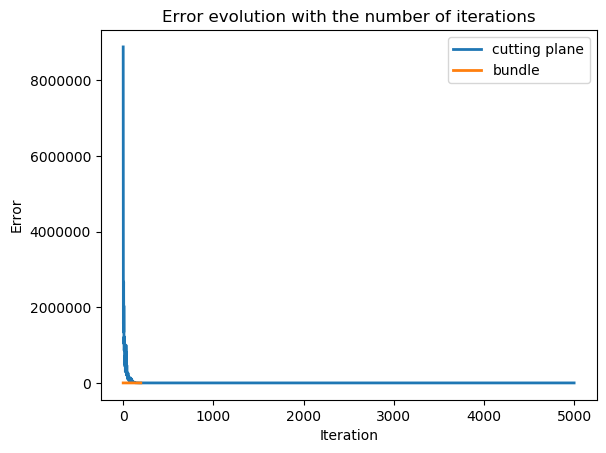

PyObject <matplotlib.legend.Legend object at 0x1545bb190>

In [26]:
plot(trace_cutting_plane_f .- optsol, lw=2., label = "cutting plane")
plot(trace_bundle_f .- optsol, lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Error")
legend()

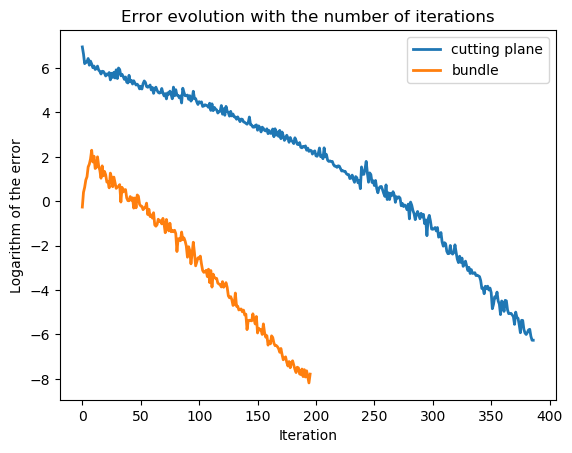

PyObject <matplotlib.legend.Legend object at 0x1546acad0>

In [27]:
plot(log10.(trace_cutting_plane_f .- optsol)[1:387], lw=2., label = "cutting plane")
plot(log10.(trace_bundle_f .- optsol), lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Logarithm of the error")
legend()

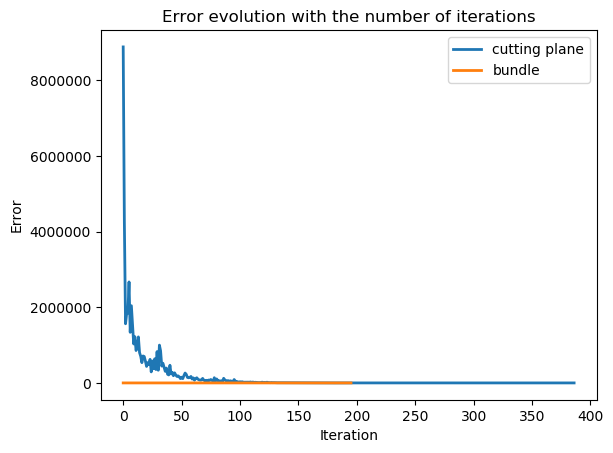

PyObject <matplotlib.legend.Legend object at 0x16bed2310>

In [28]:
plot((trace_cutting_plane_f .- optsol)[1:387], lw=2., label = "cutting plane")
plot(trace_bundle_f .- optsol, lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Error")
legend()